# Figures for Join Tree Section in Thesis

Demonstrates an approximate bi-filtration technique that tracks connected
components in Vietoris-Rips complexes (up to 1-dimensional simplices)
thresholded by distance and centrality.

The idea is inspired by Pont et al.'s (2022) work on tracking features in join
tree sequences.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import stad as sd
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist

from lib.mpp.util import minmax, normalize
from lib.mpp.JoinTree import JoinTree
from lib.mpp.SuperJoinTree import SuperJoinTree, plot_super_join_tree
from lib.mpp.JoinTreeSequence import (
    JoinTreeSequence,
    plot_join_tree_sequence,
    plot_join_tree_hierarchy_sequence,
    plot_join_tree_sequence_colormap,
)

from lib.plotting import *
palette = configure_matplotlib()
plt.rcParams["image.cmap"] = "viridis"

The cell below constructs join trees at several distance thresholds. The join
tree construction takes a graph describing the allowed edges. These graphs
always contain the minimum spanning tree to ensure a full tree can be created at
all distances. Edges up to the distance threshold are added to the minimum
spanning tree to show how branches disappear at larger distances.

Within the join tree construction, a centrality threshold is applied to the
points and connected components are tracked. Segments are created if all points
in a detected connected component are new. Segments are merged if a component is
detected that had multiple labels at the previous lens threshold. Points are
added to a segment when detected components contain new points and points with a
single previous label.

In [3]:
df = pd.read_csv('data/five_circles/five_circles.csv')[['x', 'y']]

dist = sd.sparse.from_condensed(normalize(pdist(df)))
lens = 1 - normalize(sd.lenses.eccentricity(dist))

mst = sd.masks.mst(dist, np.ones_like(dist.data, dtype=bool))
min_d, max_d = minmax(dist.data)
d_thresholds = np.linspace(min_d, max_d, 10).round(2)

trees = [
  JoinTree(sd.sparse.filter(dist.copy(), mst | (dist.data <= d)), lens)
  for d in d_thresholds
]
signal, noise = zip(*[t.simplify(0.15) for t in trees])
sequence = JoinTreeSequence(signal, noise)

Drawing the join trees shows how the branches connected at lower centrality values when larger distances are added. A topological simplification factor of $0.15$ is applied to suppress low-persistent segments in the join trees (grey segments)!

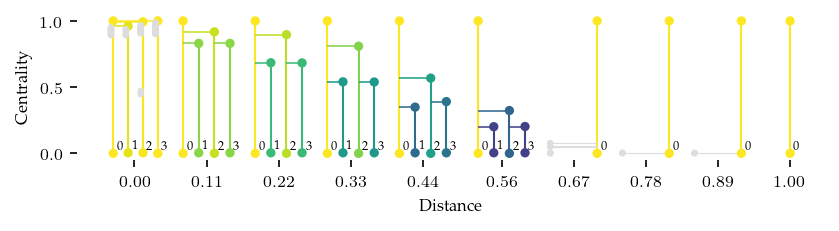

In [5]:
sized_fig(1, 0.25)
plot_join_tree_sequence(sequence, d_thresholds, text_offset=(0.01,0.05))
plt.xlabel('Distance')
plt.ylabel('Centrality')
plt.subplots_adjust(.08, .28, 0.99, 0.99)
plt.savefig('images/join_tree_sequence.pdf', pad_inches=0)
plt.show()

There is no guarantee that the segment numbers match across multiple trees.
Instead, we look at data point membership overlaps between segments in adjacent
trees. These cross-tree edges are drawn in the figure below. The join trees are
shown in a hierarchical layout where each segment is a node! The cross-tree
edges are coloured by the overlap ratio of the parent (higher distance, blue)
and child (lower distance, red) segments. These overlaps indicate where points
originated from and move to. Strong non-black colours indicate splits and merges
of the segments.

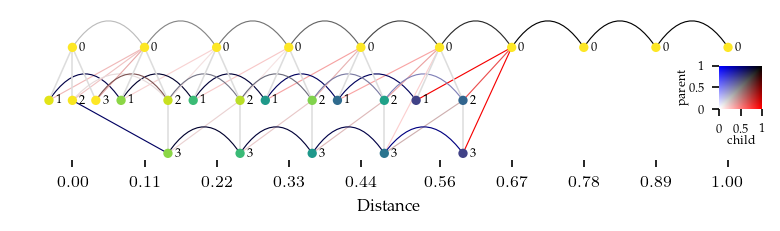

In [6]:
fig = sized_fig(1, 0.25)
plot_join_tree_hierarchy_sequence(sequence, d_thresholds, text_offset=(0.015,0))
plt.xlabel('Distance')
fig.add_subplot(3, 3, 6, anchor='E')
plot_join_tree_sequence_colormap()
plt.subplots_adjust(.08, .28, 0.99, 0.99)
plt.savefig('images/join_tree_hierarchy_sequence.pdf', pad_inches=0)
plt.show()

The cross-tree segments are simplified by keeping only the strongest incoming
and outgoing edges per segment. Edges that are included as strongest by both the
parent and child side are labelled as *core* and indicate a continuation of a
segment. Edges that are only included as strongest by the child are labelled as
*merge* and indicate a child merges into another segment to form the parent.
Similarly, edges that are only included as strongest by the parent are labelled
as *split* and indicate a child merge that split into multiple segments
(including the parent).

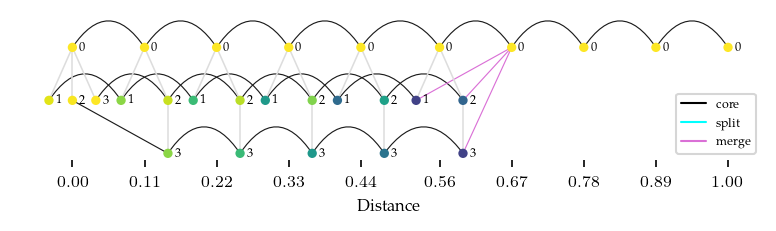

In [7]:
from matplotlib.lines import Line2D

fig = sized_fig(1, 0.25)
simple_sequence = sequence.simplify()
plot_join_tree_hierarchy_sequence(simple_sequence, d_thresholds, text_offset=(0.015, 0))
plt.legend(
    loc="lower right",
    handles=[
        Line2D([0], [0], color="black", lw=1, label="core"),
        Line2D([0], [0], color="cyan", lw=1, label="split"),
        Line2D([0], [0], color="orchid", lw=1, label="merge"),
    ],
)
plt.xlabel("Distance")
plt.subplots_adjust(0.08, 0.28, 0.99, 0.99)
plt.savefig("images/join_tree_hierarchy_sequence_simplified.pdf", pad_inches=0)
plt.show()

We can now visualise the branch hierarchy over distance, coloured and annotated
to indicate the join tree hierarchies over centrality. In the figure below,
colour indicates centrality persistence, higher values indicate longer branches.
The curved arrows indicate how the segments merge in the centrality join trees.
Straight grey lines indicate how the segments merge in the distance hierarchy.

The resulting figure summarises the data's shape as having four branching and a
slightly rectangular aspect ratio (because 2 merges into 3 and 3 has a larger
centrality before it merges into 1). 

In [8]:
super_tree = SuperJoinTree(simple_sequence, d_thresholds)

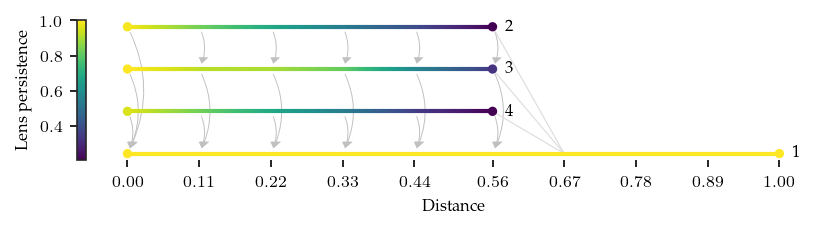

In [22]:
fig = sized_fig(1, 0.25)
fig, ax, lines = plot_super_join_tree(super_tree, text_offset=(0.025, 0))
plt.colorbar(lines, label="Lens persistence", aspect=15, pad=0.01, location='left')
plt.xlabel("Distance")
plt.yticks([])
plt.subplots_adjust(-0.05, 0.28, 0.99, 0.96)
plt.savefig("images/super_join_tree.pdf", pad_inches=0)
plt.show()

Plotting the membership (coloured by the number of distance levels points are a member of the selected segment) confirms that the segments describe the data's branches!

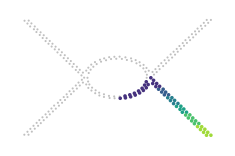

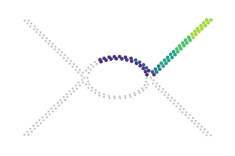

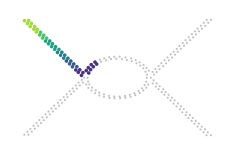

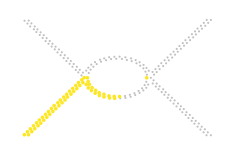

In [9]:
membership = np.zeros((len(df), 4))
for i, id in enumerate([2, 3, 4, 1]):
    for sequence_segment in super_tree.segments[id].segments.values():
        membership[sequence_segment.join_tree_segment.point_ids, i] += 1

first_nonzero = np.argmax(membership > 0, axis=1)
for i in range(4):
    mask = first_nonzero == i
    sized_fig(0.25)
    plt.scatter(
        df.x[~mask], df.y[~mask], color="silver", s=1, edgecolors="none", linewidths=0
    )
    plt.scatter(
        df.x[mask],
        df.y[mask],
        c=membership[mask, i],
        cmap="viridis",
        s=3,
        edgecolors="none",
        linewidths=0,
        vmin=0, vmax=7
    )
    plt.axis("off")
    plt.subplots_adjust(0, 0, 1, 1)
    plt.savefig(f"images/super_join_tree_{i}.pdf", pad_inches=0)
plt.show()

# plt.scatter(df.x, df.y, c=membership, cmap='viridis')

## Minimal presentation

A minimal presentation more accurately describes the segments' persistence. It is computed without adding MST edges but finds the same segments with a $0.15$ topology simplification factor over the centrality dimension.

In [4]:
from biperscan import BPSCAN
c = BPSCAN(
  metric='precomputed',
  lens=lens,
).fit(dist.data)
minpres = c.minimal_presentation_

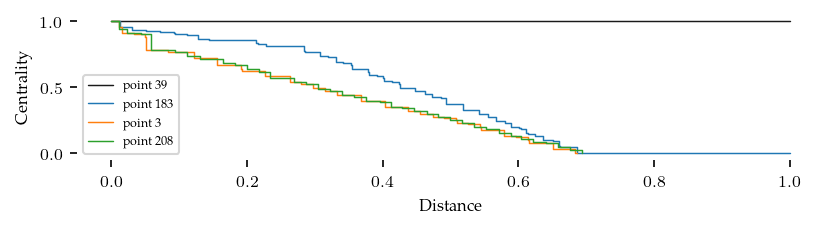

In [5]:
# Simplify as in the centrality join tree
curves = minpres.compute_value_death_curves()
persistence = curves.apply(lambda x: x[-3][0] - x[2][0])
curves = curves[persistence >= 0.15]
swap_curves = [curve[:, ::-1] for curve in curves]

# Plot curves of remaining segments
sized_fig(1, 0.25)
plt.plot(
    [0, c.distances_.max()],
    [1, 1],
    "-",
    color="k",
    lw=0.7,
    label=f"point {c._row_to_point[0]}",
)
for i, curve in enumerate(curves):
    root = c._row_to_point[curves.index[i]]
    plt.plot(*swap_curves[i][2:].T, "-", lw=0.7, label=f"point {root}")
plt.autoscale()
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Centrality")
plt.subplots_adjust(0.08, 0.28, 0.99, 0.99)
plt.savefig("images/join_tree_minpres.pdf", pad_inches=0)
plt.show()

## Limitations

This approach only works for single-cluster noiseless datasets. Datasets with
multiple clusters and noise points surrounding them generate many segments. The
ones that correspond to the clusters and their branches are probably not the most
persistent segments, making them difficult to extract!

For example, lets add uniformly distributed noise points positioned around the
cluster.

In [21]:
xi, xa = minmax(df.x.values)
yi, ya = minmax(df.y.values)

num_noise = df.shape[0] // 10
df_noisy = pd.concat(
    (
        df,
        pd.DataFrame(
            dict(
                x=np.random.uniform(0.7 * xi, 1.3 * xa, num_noise),
                y=np.random.uniform(0.7 * yi, 1.3 * ya, num_noise),
            )
        ),
    ), ignore_index=True
)

The minimum presentation computes just fine.

In [22]:
c = BPSCAN(
  metric='precomputed',
  lens='negative_eccentricity',
).fit(normalize(pdist(df_noisy)))
minpres = c.minimal_presentation_

However, it contains many more curves at the same topology simplification factor
and the curves for the branches (indicated with a *) are not easy to spot! This
happens because the branch-ends no longer correspond to the 4 most eccentric
points. There are now noise points into which the branches merge at low(ish)
distances and centrality values!

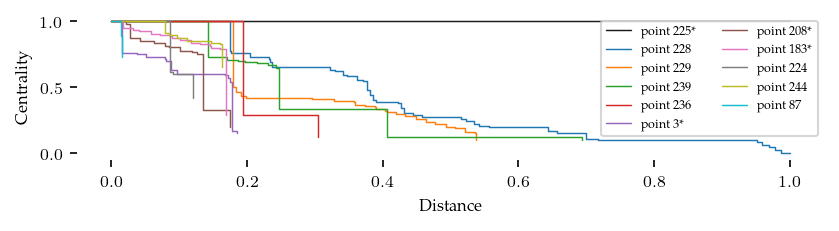

In [23]:
# Simplify as in the centrality join tree
curves = minpres.compute_value_death_curves()
persistence = curves.apply(lambda x: x[-3][0] - x[2][0])
curves = curves.loc[persistence > 0.15] #
swap_curves = [curve[:, ::-1] for curve in curves]

# Plot curves of remaining segments
sized_fig(1, 0.25)
plt.plot([0, c.distances_.max()], [1, 1], "-", color="k", lw=0.7, label=f"point {c._row_to_point[0]}*")
for i, curve in enumerate(curves):
    root = curves.index[i]
    point = c._row_to_point[root]
    star = '*' if point in [3, 39, 183, 208] else ''
    plt.plot(*swap_curves[i][2:].T, "-", lw=0.7, label=f"point {point}{star}")
plt.autoscale()
plt.legend(ncol=2)
plt.xlabel("Distance")
plt.ylabel("Centrality")
plt.subplots_adjust(.08, .28, 0.99, 0.99)
plt.savefig('images/join_tree_minpres_noisy.pdf', pad_inches=0)
plt.show()